In [5]:
import os
import json
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
sys.path.append('../')
from utils.preprocess_utils import coco_to_yolo, select_two_objects

In [6]:
!ls ../dataset/raw

annotations  image_info.p  images


In [7]:
raw_data_dir = '../dataset/raw'
image_dir = "../dataset/raw/images"

In [8]:
annotation_dir_path = os.path.join(raw_data_dir, "annotations")
with open(os.path.join(annotation_dir_path, "instances_val2017.json"), "r") as f:
    annotations = json.load(f)

In [9]:
# Get image info
import pickle
print('------ Getting image info ----------')
with open("../dataset/raw/image_info.p", "rb") as f:
    image_info = pickle.load(f)


------ Getting image info ----------


In [17]:
def selectBoxesImages(annotations):
    boxPerImage = defaultdict(list)
    for annotation in annotations["annotations"]:
            boxPerImage[annotation["image_id"]].append(annotation)
    
    tmp = {}
    for k in boxPerImage:
        boxes = select_two_objects(boxPerImage[k], image_info[k], None, None, None, None, min_size=None)
        if boxes is not None:
            tmp[k] = boxes
            
    
    boxPerImage = tmp
    return boxPerImage

def computeArea(box):
    return box[-1] * box[-2]
    # return np.sqrt(box[-1] * box[-2])

def get_min_edge(box):
    return min(box[-1], box[-2])

In [18]:
boxPerImage = selectBoxesImages(annotations)

In [21]:
import copy
all_smallest, all_largest, sizes = [], [], []
invalid_box = 0
total_box = 0
for vid, boxes in boxPerImage.items():
    basename = f"{vid:012d}"
    img_w, img_h = image_info[vid]["size"]
    ratio = image_info[vid]["ratio"]
    ratio = 640 / max(img_w, img_h)
    # print(640, image_info[basename][0], image_info[basename][1])
    for i, box in enumerate(boxes):
        total_box += 1
        box = copy.deepcopy(box["bbox"])
        _, _, bw, bh = box
        if bw > img_w or bh > img_h or bw < 0 or bh < 0:
            invalid_box += 1
            continue
            
        box[-2] = box[-2] * ratio
        box[-1] = box[-1] * ratio
        # print(box[-1], box[-2],ratio)
        # box[-1] = box[-1] / image_info[vid][0]
        # box[-2] = box[-2] / image_info[vid][1]
        
        if i == 0:
            all_smallest.append(computeArea(box))
        else:
            all_largest.append(computeArea(box))
        
        print(box[-1], box[-2], ratio, img_w, img_h)
        sizes.append(get_min_edge(box))

28.67 38.65 1.0 529 640
106.45 339.79 1.0 529 640
73.53 27.44 1.0 640 480
220.79 261.04 1.0 640 480
24.491503267973858 28.695424836601312 1.0457516339869282 612 612
408.84705882352944 524.4235294117648 1.0457516339869282 612 612
211.01 240.66 1.0 640 498
251.02 400.22 1.0 640 498
16.0 21.22 1.0 427 640
347.61 180.35 1.0 427 640
23.96 24.45 1.0 640 425
285.91 188.88 1.0 640 425
128.07 45.2 1.0 640 480
314.84 466.58 1.0 640 480
8.03 11.83 1.0 426 640
365.32 330.99 1.0 426 640
58.62 79.38 2.0 320 240
164.78 213.58 2.0 320 240
10.48 9.47 1.0 640 427
330.31 148.4 1.0 640 427
71.03 30.75 1.0 360 640
284.76 183.1 1.0 360 640
162.88 341.93 1.0 640 480
393.7 367.51 1.0 640 480
81.29 84.99 1.0 640 364
329.64 632.64 1.0 640 364
82.99 183.12 1.0 640 480
463.58 467.44 1.0 640 480
17.46 18.79 1.0 640 512
357.42 136.29 1.0 640 512
13.97 17.46 1.0 640 480
346.84 515.09 1.0 640 480
5.76 15.22 1.0 640 485
201.84 197.92 1.0 640 485
29.19 55.87 1.0 640 588
342.23 177.06 1.0 640 588
81.14 16.82 1.0 640 429

In [22]:
print("invalid_box", invalid_box, "total_box", total_box, "ratio", invalid_box / total_box)

invalid_box 0 total_box 8718 ratio 0.0


In [23]:
all_smallest = np.array(all_smallest)
all_largest = np.array(all_largest)
sizes = np.array(sizes)

In [24]:
# all_smallest = np.array([computeArea(k[0]["bbox"]) for k in boxPerImage.values()])
# all_largest = np.array([computeArea(k[1]["bbox"]) for k in boxPerImage.values()])
# sizes = np.array([min(get_min_edge(k[0]["bbox"]), get_min_edge(k[1]["bbox"])) for k in boxPerImage.values()])

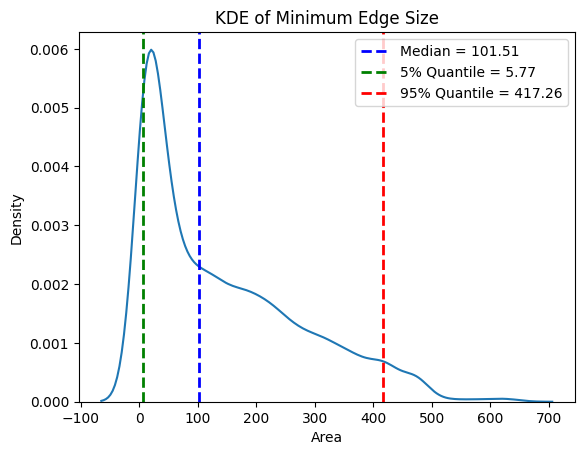

In [25]:

small_quantile_05 = np.quantile(sizes,  0.05)
small_quantile_95 = np.quantile(sizes, 0.95)
sns.kdeplot(sizes)
# plt.axvline(np.mean(all_smallest), color='r', linestyle='dashed', linewidth=2, label=f'Mean = {np.mean(all_smallest):.2f}')
plt.axvline(np.median(sizes), color='b', linestyle='dashed', linewidth=2, label=f'Median = {np.median(sizes):.2f}')
plt.axvline(small_quantile_05, color='g', linestyle='dashed', linewidth=2, label=f'5% Quantile = {small_quantile_05:.2f}')
plt.axvline(small_quantile_95, color='r', linestyle='dashed', linewidth=2, label=f'95% Quantile = {small_quantile_95:.2f}')
plt.title("KDE of Minimum Edge Size")
plt.xlabel("Area")
plt.legend()
plt.plot()
plt.savefig("KDE_Size.png", dpi=300, bbox_inches='tight')

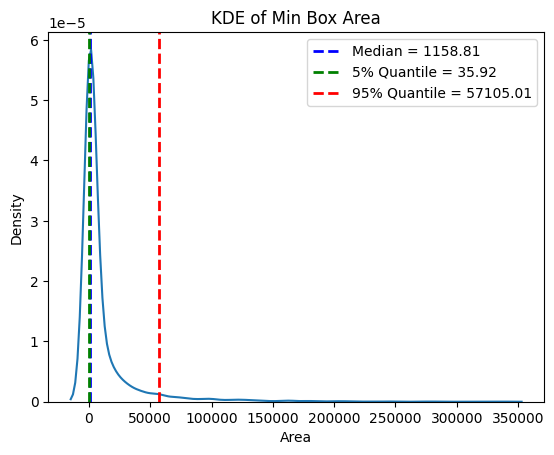

In [26]:
all_smallest, counts = np.unique(all_smallest, return_counts=True)
counts = counts / sum(counts)
# print(all_smallest.shape, counts)

small_quantile_05 = np.quantile(all_smallest,  0.05)
small_quantile_95 = np.quantile(all_smallest, 0.95)
sns.kdeplot(all_smallest)
# plt.axvline(np.mean(all_smallest), color='r', linestyle='dashed', linewidth=2, label=f'Mean = {np.mean(all_smallest):.2f}')
plt.axvline(np.median(all_smallest), color='b', linestyle='dashed', linewidth=2, label=f'Median = {np.median(all_smallest):.2f}')
plt.axvline(small_quantile_05, color='g', linestyle='dashed', linewidth=2, label=f'5% Quantile = {small_quantile_05:.2f}')
plt.axvline(small_quantile_95, color='r', linestyle='dashed', linewidth=2, label=f'95% Quantile = {small_quantile_95:.2f}')
plt.title("KDE of Min Box Area")
plt.xlabel("Area")
plt.legend()
plt.plot()
plt.savefig("KDE_MinBox.png", dpi=300, bbox_inches='tight')

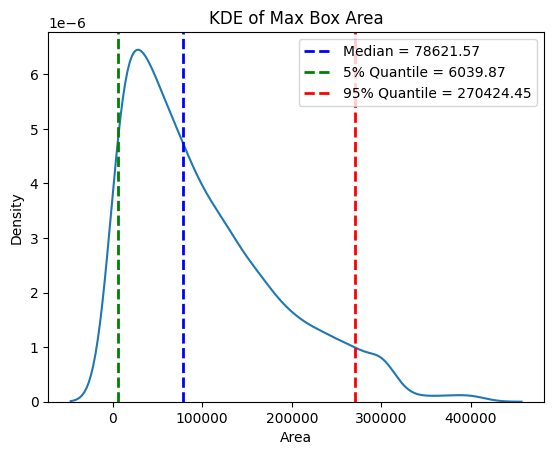

In [27]:
all_largest, counts = np.unique(all_largest, return_counts=True)


large_quantile_05 = np.quantile(all_largest,  0.05)
large_quantile_95 = np.quantile(all_largest, 0.95)
sns.kdeplot(all_largest)
plt.axvline(np.median(all_largest), color='b', linestyle='dashed', linewidth=2, label=f'Median = {np.median(all_largest):.2f}')
plt.axvline(large_quantile_05, color='g', linestyle='dashed', linewidth=2, label=f'5% Quantile = {large_quantile_05:.2f}')
plt.axvline(large_quantile_95, color='r', linestyle='dashed', linewidth=2, label=f'95% Quantile = {large_quantile_95:.2f}')
plt.title("KDE of Max Box Area")
plt.xlabel("Area")
plt.legend()
plt.plot()
plt.savefig("KDE_MaxBox.png", dpi=300, bbox_inches='tight')

There is an overlapping between the range of the largest and smalest boxes

In [28]:
def draw_overlapping(range1, range2, name):
    # Determine the overlapping region
    overlap_start = max(range1[0], range2[0])
    overlap_end = min(range1[1], range2[1])

    # Create a figure and axis
    plt.figure(figsize=(8, 2))
    ax = plt.gca()

    # Plot the first range
    plt.barh(0, range1[1] - range1[0], left=range1[0], height=0.2, label='Range 1', color='blue')

    # Plot the second range
    plt.barh(0, range2[1] - range2[0], left=range2[0], height=0.2, label='Range 2', color='orange')

    # Plot the overlapping region
    if overlap_start < overlap_end:
        plt.barh(0, overlap_end - overlap_start, left=overlap_start, height=0.2, label='Overlap', color='green',
                 alpha=.6)

    # Set labels and legend
    plt.title("The overlap between the ranges of the smallest and largest box areas")
    plt.xlabel('Area')
    plt.yticks([])
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.savefig(name, bbox_inches='tight', dpi=300)
    plt.show()

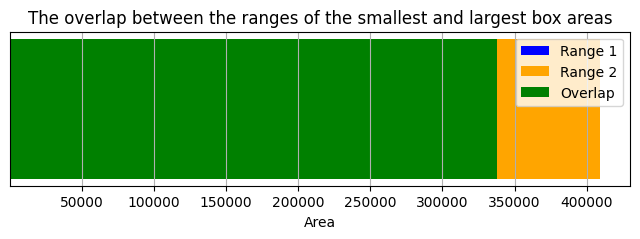

In [29]:
draw_overlapping((all_smallest.min(), all_smallest.max()), 
                 (all_largest.min(), all_largest.max()), "Overlapping1.png")

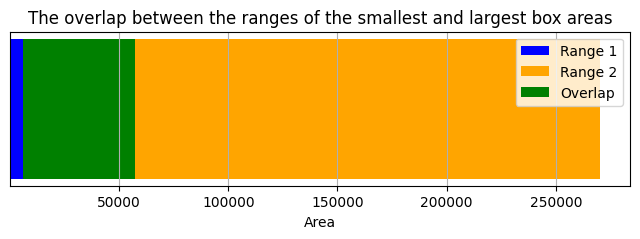

In [30]:
draw_overlapping((small_quantile_05, small_quantile_95), 
                 (large_quantile_05, large_quantile_95),
                 "Overlapping2.png")


In [32]:
def get_statistics(data):
    return data.min(), data.max(), data.mean(), np.median(data)

print(get_statistics(all_smallest))
print(get_statistics(all_largest))
print(get_statistics(sizes))

(2.5134, 338032.227, 10775.554635771538, 1158.8056000000001)
(136.11302912000002, 409600.0, 101272.56808938959, 78621.5727)
(0.86, 640.0, 142.22352492394162, 101.5134)


In [66]:
np.histogram(, 20)

(array([3707,  301,  114,   79,   51,   30,   17,   20,   11,   10,    6,
           3,    3,    1,    0,    0,    2,    0,    0,    1]),
 array([2.51340000e+00, 1.69039991e+04, 3.38054848e+04, 5.07069704e+04,
        6.76084561e+04, 8.45099418e+04, 1.01411427e+05, 1.18312913e+05,
        1.35214399e+05, 1.52115885e+05, 1.69017370e+05, 1.85918856e+05,
        2.02820342e+05, 2.19721827e+05, 2.36623313e+05, 2.53524799e+05,
        2.70426284e+05, 2.87327770e+05, 3.04229256e+05, 3.21130741e+05,
        3.38032227e+05]))

In [90]:
import pandas as pd

def divide_into_bins(keys, data, n_bins):
    labels = pd.qcut(data, n_bins)
    out = defaultdict(list)
    for i in range(len(labels)):
        out[labels[i]].append((keys[i], data[i]))
        
    return out
        

In [92]:
boxPerImage.keys()

dict_keys([289343, 61471, 472375, 579321, 494869, 554002, 78823, 419974, 404484, 329219, 68078, 170893, 65485, 498286, 424162, 61108, 67213, 365207, 279278, 482100, 540502, 127182, 565776, 575970, 462614, 407614, 522007, 226984, 37777, 491216, 136355, 529568, 306733, 42276, 370818, 464476, 68833, 433915, 149222, 17379, 361586, 127987, 186632, 440475, 368900, 9772, 525083, 383443, 240940, 435003, 17899, 70774, 508602, 123585, 157807, 109055, 23272, 134096, 501523, 125850, 284623, 245764, 466156, 402473, 10363, 172330, 211042, 361621, 554291, 227044, 530099, 223747, 209747, 153217, 47121, 176778, 568690, 176857, 107087, 260925, 327769, 7386, 17178, 261888, 29187, 368335, 367680, 234807, 507975, 338304, 555050, 206135, 117914, 465129, 506310, 319696, 102707, 435880, 442009, 519569, 178028, 446574, 290768, 182611, 266206, 228214, 453302, 293390, 384808, 512476, 425226, 292005, 480122, 262440, 197796, 500464, 481386, 397133, 173302, 354072, 523100, 62025, 84241, 569917, 547816, 222825, 7420

In [84]:
len(out), len(all_smallest)

(4356, 4356)

In [82]:
bins

array([2.51340000e+00, 6.15776000e+01, 1.47134100e+02, 3.05054050e+02,
       5.56605300e+02, 1.07434095e+03, 2.14290930e+03, 4.40175230e+03,
       1.07670547e+04, 2.75275260e+04, 3.38032227e+05])

In [94]:
from collections import defaultdict
groups = defaultdict(list)

for i in range(len(out)):
    groups[out[i]].append(all_smallest[i])

In [95]:
for k in groups:
    print(len(groups[k]))

436
436
435
436
435
436
435
436
435
436


In [ ]:
k